In [11]:
import pandas as pd
import geopandas as gp 
import json
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%matplotlib inline
from tqdm import tqdm


In [12]:
GP_allotment = json.load(open('GP_LSOA_PATIENTSDIST.json','rb'))

In [13]:
patients_pop = pd.read_csv('../BL_Work/grondTruths/GP_SYOA.csv')

In [37]:
patients_registered_GP = {}
for index , row in patients_pop.iterrows():
    patients_registered_GP[row['PRACTICE_CODE']] = row['Total_All']

In [14]:
np.sum(patients_pop['Total_All'])

56938269

In [15]:
mapping_codes= pd.read_csv('../BL_Work/grondTruths/INDICATOR_MAPPINGS.csv')
mapping_codes.head(n=100)

,INDICATOR_CODE,INDICATOR_DESCRIPTION,INDICATOR_POINT_VALUE,INDICATOR_GROUP_CODE,INDICATOR_GROUP_DESCRIPTION,DOMAIN_CODE,DOMAIN_DESCRIPTION,PATIENT_LIST_TYPE
0,AF001,The contractor establishes and maintains a reg...,5,AF,Atrial fibrillation,CL,Clinical,TOTAL
1,AF006,The percentage of patients with atrial fibrill...,12,AF,Atrial fibrillation,CL,Clinical,TOTAL
2,AF007,In those patients with atrial fibrillation wit...,12,AF,Atrial fibrillation,CL,Clinical,TOTAL
3,AST001,The contractor establishes and maintains a reg...,4,AST,Asthma,CL,Clinical,TOTAL
4,AST002,The percentage of patients aged 8 or over with...,15,AST,Asthma,CL,Clinical,TOTAL
5,AST003,"The percentage of patients with asthma, on the...",20,AST,Asthma,CL,Clinical,TOTAL
6,AST004,The percentage of patients with asthma aged 14...,6,AST,Asthma,CL,Clinical,TOTAL
7,BP002,The percentage of patients aged 45 or over who...,15,BP,Blood pressure,PH,Public Health,45OV
8,CAN001,The contractor establishes and maintains a reg...,5,CAN,Cancer,CL,Clinical,TOTAL
9,CAN003,"The percentage of patients with cancer, diagno...",6,CAN,Cancer,CL,Clinical,TOTAL


In [18]:
%store -r Open_filtered_GPs

In [63]:
Diseases = []
for name, group in mapping_codes.groupby('INDICATOR_GROUP_CODE'):
    Diseases.append(name)
    print name , set(group['INDICATOR_GROUP_DESCRIPTION'])

AF set(['Atrial fibrillation'])
AST set(['Asthma'])
BP set(['Blood pressure'])
CAN set(['Cancer'])
CHD set(['Secondary prevention of coronary heart disease'])
CKD set(['Chronic kidney disease'])
CON set(['Contraception'])
COPD set(['Chronic obstructive pulmonary disease'])
CS set(['Cervical screening'])
CVDPP set(['Cardiovascular disease \x96 primary prevention'])
DEM set(['Dementia'])
DEP set(['Depression'])
DM set(['Diabetes mellitus'])
EP set(['Epilepsy'])
HF set(['Heart failure'])
HYP set(['Hypertension'])
LD set(['Learning Disability'])
MH set(['Mental health'])
OB set(['Obestity'])
OST set(['Osteoporosis: secondary prevention of fragility fractures'])
PAD set(['Peripheral arterial disease'])
PC set(['Palliative care'])
RA set(['Rheumatoid arthritis'])
SMOK set(['Smoking'])
STIA set(['Stroke and transient ischaemic attack'])


In [20]:
prevalence_df = pd.read_csv('../BL_Work/grondTruths/PREVALENCE.csv')
prevalence_df = prevalence_df.dropna()
prevalence_df.head()

,PRACTICE_CODE,INDICATOR_GROUP_CODE,REGISTER,PATIENT_LIST_TYPE,PATIENT_LIST_SIZE
0,A81001,AF,106.0,TOTAL,4150
1,A81001,AST,306.0,TOTAL,4150
2,A81001,CAN,118.0,TOTAL,4150
3,A81001,CHD,171.0,TOTAL,4150
4,A81001,CKD,188.0,18OV,3314


In [22]:
prevalence_df_filtered = prevalence_df[prevalence_df['PRACTICE_CODE'].isin(Open_filtered_GPs)]

In [24]:
len(prevalence_df_filtered) , len(prevalence_df)

(143008, 153928)

In [28]:
# GP_allotment

In [77]:
df = pd.read_csv('../BL_Work/Lower_Layer_Super_Output_Area_2011_to_Ward_2015_Lookup_in_England_and_Wales.csv')

In [90]:
wardMap = {}
for name , group in df.groupby('LAD15CD'):
    wardMap[name] = list(group['LSOA11CD'])

In [31]:
GP_Survey_Prevalence = {}
for name , group in prevalence_df_filtered.groupby('PRACTICE_CODE'):
    for index , row in group.iterrows():
        if row['INDICATOR_GROUP_CODE'] not in GP_Survey_Prevalence:
            GP_Survey_Prevalence[row['INDICATOR_GROUP_CODE']] = {}
        GP_Survey_Prevalence[row['INDICATOR_GROUP_CODE']][row['PRACTICE_CODE']] = float(row['REGISTER'])/float(row['PATIENT_LIST_SIZE'])
    

In [79]:
GP_Survey_Prevalence

{'AF': {'E84702': 0.006820396232543034,
  'E84701': 0.0035236081747709656,
  'E84704': 0.00911854103343465,
  'E84709': 0.008711832868138375,
  'Y05622': 0.008808885484488702,
  'B85014': 0.021197777320436303,
  'B85015': 0.01794325445777728,
  'B85016': 0.010832559579077685,
  'B85010': 0.01738122827346466,
  'B85012': 0.01712076583210604,
  'B85018': 0.011297539149888142,
  'B85019': 0.02349580223880597,
  'N81032': 0.022905925111993915,
  'N81033': 0.02853566958698373,
  'N81030': 0.032372615410025604,
  'N81031': 0.03786544557942938,
  'N81036': 0.01981386970879616,
  'N81037': 0.02115570599613153,
  'N81034': 0.02090320567818423,
  'N81035': 0.03127450980392157,
  'N81038': 0.028007075471698114,
  'N81039': 0.024482982472410274,
  'N82046': 0.01596949112143964,
  'N82041': 0.02976922026491875,
  'N82048': 0.02663934426229508,
  'N82049': 0.016402210732750937,
  'G82162': 0.024295630869742752,
  'G82160': 0.03928888888888889,
  'G82161': 0.015442987419290422,
  'G82164': 0.01545746

In [81]:
DiseasePop_GP= {}
for d in GP_Survey_Prevalence:
    if d not in DiseasePop:
        DiseasePop_GP[d] = {}
    for k in GP_Survey_Prevalence[d]:
        if k in patients_registered_GP:
            DiseasePop_GP[d][k] = GP_Survey_Prevalence[d][k]*patients_registered_GP[k]

In [83]:
# DiseasePop_GP

In [97]:
DiseasePop_byWard = {} 
Ward_patients = {}
for d in GP_Survey_Prevalence:
    if d not in DiseasePop_byWard:
        DiseasePop_byWard[d] = {}
    if d not in Ward_patients:
        Ward_patients[d] = {}
    for k in GP_Survey_Prevalence[d]:
        if k in patients_registered_GP and k in GP_allotment:
            pop = GP_Survey_Prevalence[d][k]*patients_registered_GP[k]
            for ward in GP_allotment[k]:
                if ward not in DiseasePop_byWard[d]:
                    DiseasePop_byWard[d][ward] = 0.0
                if ward not in Ward_patients[d]:
                    Ward_patients[d][ward] = 0.0
                DiseasePop_byWard[d][ward] += pop * GP_allotment[k][ward]
                Ward_patients[d][ward]+= patients_registered_GP[k] * GP_allotment[k][ward]

In [92]:
# DiseasePop_byWard['AF']

{u'E01014080': 23.55205532246547,
 u'E01014081': 25.764584511944864,
 u'E01014082': 26.082620194200555,
 u'E01014083': 14.652142972131259,
 u'E01014084': 14.871659704718883,
 u'E01014085': 14.577432324482107,
 u'E01014086': 20.269355367594333,
 u'E01014087': 10.60724847254439,
 u'E01014088': 11.054308969121283,
 u'E01014089': 13.315412934505366,
 u'E01015977': 35.52587430373453,
 u'E01015976': 20.154435024574987,
 u'E01015975': 28.42433224205937,
 u'E01015974': 26.258755500677506,
 u'E01015973': 29.65006006629102,
 u'E01015972': 21.30137198076835,
 u'E01015971': 29.746714270037256,
 u'E01015970': 19.85131314689882,
 u'E01015979': 25.634206377931616,
 u'E01015978': 25.200343281809,
 u'E01010259': 24.811606060654373,
 u'E01010258': 28.48957997171499,
 u'E01010251': 38.6454039556683,
 u'E01010250': 31.19929958758232,
 u'E01010253': 29.54885374963324,
 u'E01010252': 39.1358304994786,
 u'E01010255': 47.80121727431517,
 u'E01010254': 36.094147967049665,
 u'E01010257': 40.2602788488563,
 u'E0

In [94]:
prevalence_UK_GT = {}
for d in tqdm(DiseasePop_byWard.keys()):
    if d not in prevalence_UK_GT:
        prevalence_UK_GT[d] = {}
    for k in tqdm(wardMap):
        commonKeys = list(set(DiseasePop_byWard[d].keys()).intersection(wardMap[k]))
        for lsoa in commonKeys:
            disease_patients = np.sum([DiseasePop_byWard[d][lsoa] for w in wardMap[k] if not np.isnan(DiseasePop_byWard[d][lsoa])])
            ward_patient_pop = np.sum([Ward_patients[d][lsoa] for w in wardMap[k] if not np.isnan(Ward_patients[d][lsoa])])
            prev = float(disease_patients)/float(ward_patient_pop)
            prevalence_UK_GT[d][k] = prev


 68%|██████▊   | 237/348 [00:09<00:04, 24.60it/s]


 42%|████▏     | 146/348 [00:05<00:07, 26.22it/s]


 19%|█▉        | 66/348 [00:02<00:10, 27.66it/s]


 87%|████████▋ | 302/348 [00:12<00:01, 24.14it/s]


100%|██████████| 21/21 [04:55<00:00, 14.08s/it]s]


In [96]:
%store prevalence_UK_GT

Stored 'prevalence_UK_GT' (dict)


In [98]:
Ward_prevalence = {k:DiseasePop_byWard['DEP'][k]/Ward_patients['DEP'][k] for k in Ward_patients['DEP']}

In [99]:
%store Ward_prevalence
%store DiseasePop_byWard
%store Ward_patients

Stored 'Ward_prevalence' (dict)
Stored 'DiseasePop_byWard' (dict)
Stored 'Ward_patients' (dict)


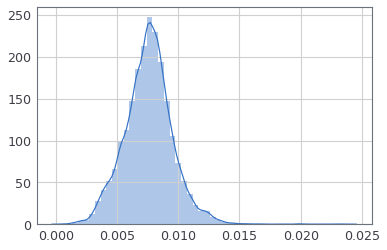

In [68]:
sns.distplot(Ward_prevalence.values())

In [48]:
%store DiseasePop_byWard

Stored 'DiseasePop_byWard' (dict)


In [43]:
len(DiseasePop) , len(patients_registered_GP)

(6781, 7835)

In [44]:
sum(DiseasePop.values())

3514534.2542738477